- 최초 텍스트 입력 데이터의 형태 : `[batch_size x length]`
- 최종 출력 : `[batch_size x length x vocab_size]`

-> 매 step마다 vocab_size만큼의 클래스 개수 중에 적당한 단어를 선택하는 작업을 length만큼 반복하는 것이 번역 문제이기 때문.

**모델 구성(각 레이어 통과시마다 텐서 shape 형태)**
1. 입력 데이터 : `[ batch_size x length ]`
2. Source & Target Embedding : `[ batch_size x length x d_emb ]`
3. Positional Encoding : 변화없음(2번의 결과에 더해지므로)
4. Multi-Head Attention
  - Split Heads : `[ batch_size x length x heads x (d_emb / n_heads) ]`
  - Masking for Masked Attention
  - Scaled Dot Product Attention
  - Combine Heads : `[ batch_size x length x d_emb ]`
5. Residual Connection
6. Layer Normalization
7. Position-wise Feed-Forward Network : `[ batch_size x length x d_ff ]`
8. Output Linear Layer : `[ batch_size x length x vocab_size ]`

In [1]:
# 한글 실행하기 위해
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

<br><br><br><br>

# Positional Encoding
![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/GN-5-L-5.jpg)


$$PE_{(pos, 2i)} = sin(pos/10000^{2i/d_{model}}) \\ PE_{(pos, 2i+1)} = cos(pos/10000^{2i/d_{model}})$$


- [어떻게 단어의 위치 정보를 포함시킬 수 있을까? - blog 1](https://skyjwoo.tistory.com/entry/positional-encoding%EC%9D%B4%EB%9E%80-%EB%AC%B4%EC%97%87%EC%9D%B8%EA%B0%80)
- [어떻게 단어의 위치 정보를 포함시킬 수 있을까? - blog 2](https://pongdangstory.tistory.com/482)

- sin, cos함수를 차원의 홀수, 짝수에 따라 사용하는 이유
  - 위치가 커질 때마다 그 값이 다시 작아져(주기함수의 특징), **어떤 특정 두 토큰의 위치값이 동일해질 수 있는 것을 방지하기 위함**이다.

In [3]:
# pos - 단어가 위치한 Time-step(각각의 토큰의 위치정보값이며 정수값을 의미)
# d_model - 모델의 Embedding 차원 수
# i - Encoding차원의 index

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)  # np.power(a,b) > a^b(제곱)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

In [4]:
pos = 7
d_model = 4
i = 0

print("Positional Encoding 값:\n", positional_encoding(pos, d_model))

print("")
print("")
print("1번째 열과 2번째 열을 4번째 행까지 ([0, 0~3], [1, 0~3]) 하드 코딩")
print("")
print("if pos == 0, i == 0: ", np.sin(0 / np.power(10000, 2 * i / d_model)))
print("if pos == 1, i == 0: ", np.sin(1 / np.power(10000, 2 * i / d_model)))
print("if pos == 2, i == 0: ", np.sin(2 / np.power(10000, 2 * i / d_model)))
print("if pos == 3, i == 0: ", np.sin(3 / np.power(10000, 2 * i / d_model)))

print("")
print("if pos == 0, i == 1: ", np.cos(0 / np.power(10000, 2 * i + 1 / d_model)))
print("if pos == 1, i == 1: ", np.cos(1 / np.power(10000, 2 * i + 1 / d_model)))
print("if pos == 2, i == 1: ", np.cos(2 / np.power(10000, 2 * i + 1 / d_model)))
print("if pos == 3, i == 1: ", np.cos(3 / np.power(10000, 2 * i + 1 / d_model)))

Positional Encoding 값:
 [[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.99500417  0.00999983  0.9999995 ]
 [ 0.90929743  0.98006658  0.01999867  0.999998  ]
 [ 0.14112001  0.95533649  0.0299955   0.9999955 ]
 [-0.7568025   0.92106099  0.03998933  0.999992  ]
 [-0.95892427  0.87758256  0.04997917  0.9999875 ]
 [-0.2794155   0.82533561  0.05996401  0.999982  ]]


1번째 열과 2번째 열을 4번째 행까지 ([0, 0~3], [1, 0~3]) 하드 코딩

if pos == 0, i == 0:  0.0
if pos == 1, i == 0:  0.8414709848078965
if pos == 2, i == 0:  0.9092974268256817
if pos == 3, i == 0:  0.1411200080598672

if pos == 0, i == 1:  1.0
if pos == 1, i == 1:  0.9950041652780258
if pos == 2, i == 1:  0.9800665778412416
if pos == 3, i == 1:  0.955336489125606


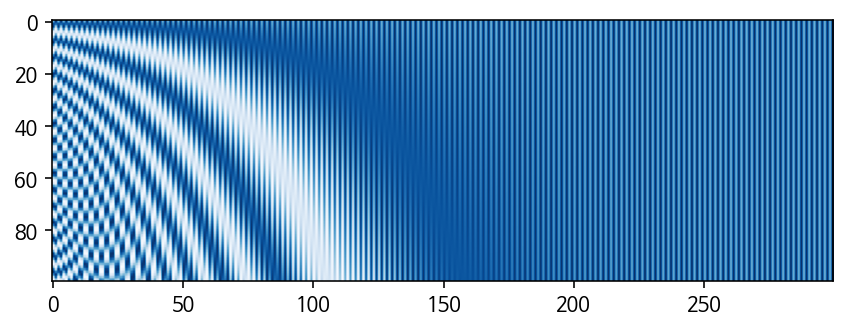

In [5]:
# Position 값이 각 Time-step 별로 고유하다는 것을 시각화를 통해 확인
# 세로축 - Time-step
# 가로축 - Word Embedding에 더해질 position 값
plt.figure(figsize=(7, 7))
plt.imshow(positional_encoding(100, 300), cmap='Blues')
plt.show()

<br><br><br><br>

# Multi-Head Attention
![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/GN-5-L-8.jpg)

- Multi-Head Attention은 여러 개의 서브 모듈을 결합하여 완성된다.
    - split_heads() : Embedding된 입력을 Head 수로 분할
    - scaled_dot_product_attention() : 분할된 입력으로부터 Attention 값을 구함
    - combine_heads() : 연산이 종료되고 분할된 Head를 다시 하나로 결합
- Masking : 마스크의 형태를 결정하는 것이 모델 외부의 훈련 데이터이기 때문에 이를 생성하는 함수는 Multi-Head Attention 외부에 정의

In [6]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)  # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        # Scaled QK 값 구하기
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None:
            scaled_qk += (mask * -1e9)

        # 1. Attention Weights 값 구하기 -> attentions
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        # 2. Attention 값을 V에 곱하기 -> out
        out = tf.matmul(attentions, V)

        return out, attentions
    
    def split_heads(self, x):
        """
        Embedding된 입력을 head의 수로 분할하는 함수
        
        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        return split_x
    
    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수
        
        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))
        return combined_x
    
    def call(self, Q, K, V, mask):
        """
        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out
        """
        WQ = self.W_q
        WK = self.W_k
        WV = self.W_v
        
        WQ_split = self.split_heads(WQ)
        WK_split = self.split_heads(WK)
        WV_split = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_split, WK_split, WV_split, mask
        )

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

<br><br><br><br>

# Position-wise Feed-Forward Network
![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/GN-5-L-17.jpg)

d_ff 는 논문의 설명대로라면 2048 일 거고, d_model 은 512 겠죠? `[ batch x length x d_model ]` 의 입력을 받아 w_1 이 2048차원으로 매핑하고 활성함수 ReLU를 적용한 후, 다시 w_2 를 통해 512차원으로 되돌리는 과정

In [7]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)
        
    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
        return out

<br><br><br><br>

![](https://aiffelstaticprd.blob.core.windows.net/media/images/GN-5-P_transformer_table01.max-800x600.png)

# Encoder 레이어 구현하기

In [8]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        # Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out)
        out = self.do(out)
        out += residual
        
        # Position-Wise Feed Forward Network
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

# Decoder 레이어 구현하기

In [9]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        
        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        # Masked Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.do(out)
        out += residual
        
        # Multi-Head Attention
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.do(out)
        out += residual
        
        # Position-Wise Feed Forward Network
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, dec_attn, dec_enc_attn

<br><br><br><br>

# Encoder

In [10]:
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
            
        return out, enc_attns

# Decoder

In [11]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        
        return out, dec_attns, dec_enc_attns

<br><br><br><br>

# Transformer

In [12]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size,
                 pos_len, dropout=0.2, shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        # 1. Embedding Layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        
        # 2. Positional Encoding 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)
        
        # 3. Encoder / Decoder 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        # 4. Output Linear 정의
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        # 5. Shared Weights
        self.shared = shared
        
        if shared:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))
        
        # 6. Dropout 정의
        self.do = tf.keras.layers.Dropout(dropout)
        
        
    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)
        
        if self.shared:
            out *= tf.math.sqrt(self.d_model)
        
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)
        
        return out
    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        # Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)
        
        # Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        # Step 3: Decoder(dec_in, enc_out, mask) -> dec_out, dec_attns, dec_enc_attns
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        # Step 4: Out Linear(dec_out) -> logits
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns


<br><br><br><br>

# Masking

In [13]:
# Attention을 할 때에 <PAD> 토큰에도 Attention을 주는 것을 방지해 주는 역할
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

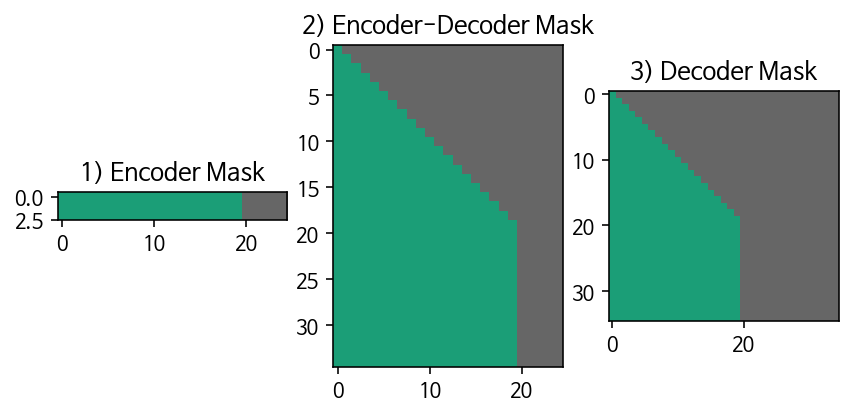

In [14]:
batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

<br><br><br><br>

# Learning Rate

In [15]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)